In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import re

import nltk 
from nltk.corpus import stopwords, words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import plot_confusion_matrix, roc_curve
from sklearn.decomposition import NMF
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

nltk.download('words')
nltk.data.path.append("/home/nltk_data")

[nltk_data] Downloading package words to /home/ubuntu/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
#### chyron archive web address: https://archive.org/services/third-eye.php

import datetime

# pull chyrons from web as dataframes
def get_dfs(start_y=2017, start_m=9, start_d=7, end_today=True, end_y=None, end_m=None, end_d=None):
    
    first = datetime.date(start_y, start_m, start_d)
    delta = datetime.timedelta(weeks=1)
    last = first + delta
    dfs = []
    iters = 0
    
    if end_today:
        stop = datetime.date.today()
    else:
        stop = datetime.date(end_y, end_m, end_d)
    
    while first < stop:
        if iters > 210:
            break
        else:
            print(iters)
            first_str = first.strftime('%m/%d/%y')
            last_str = last.strftime('%m/%d/%y')
            url = f'https://archive.org/services/third-eye.php?dayL={first_str}&dayR={last_str}'
            df = pd.read_csv(url, delimiter='\t')
            dfs.append(df)

            first = last + datetime.timedelta(days=1)
            last = first + delta
            
            if last > stop:
                last = stop
                
            iters += 1
        
    return dfs

# cleans dfs
def clean_dfs(df, csv=True, concat=False, csv_name='chyron_next'):
    
    # stack dfs from list
    if concat:
        df = pd.concat(df, ignore_index=True)
        
    # drop duplicates
    df.drop_duplicates(subset=['text'], keep='first', inplace=True, ignore_index=True)
    
    # count words in chyron 
    df['num_words'] = df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 'NaN')
    
    # save to local csv          
    if csv:
        df.to_csv(f'/Users/jonleckie/Desktop/DSI_all/capstones/capstone_two/chyrons/{csv_name}.csv')    
    
    return df

# wrapper for above functions --> NOT TESTED
def get_chyrons(start_y=2017, start_m=9, start_d=7, end_today=True, end_y=None, end_m=None, end_d=None):
    df = get_dfs(start_y, start_m, start_d, end_today, end_y, end_m, end_d)
    df = clean_dfs(df, csv=True, concat=False, csv_name='chyron2')
    return df

In [95]:
chyrons.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652398 entries, 0 to 2652397
Data columns (total 6 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   date_time_(UTC)               2652398 non-null  object 
 1   channel                       2652397 non-null  object 
 2   duration                      2652397 non-null  float64
 3   https://archive.org/details/  2647435 non-null  object 
 4   text                          2652397 non-null  object 
 5   num_words                     205492 non-null   float64
dtypes: float64(2), object(4)
memory usage: 121.4+ MB


### Distributions of word counts:

* All networks

(array([9.24212e+05, 9.55745e+05, 7.21145e+05, 5.18620e+04, 1.21500e+03,
        1.29000e+02, 1.70000e+01, 1.00000e+01, 7.00000e+00, 4.00000e+00]),
 array([1.0, 13.4, 25.8, 38.2, 50.6, 63.0, 75.4, 87.8, 100.2,
        112.60000000000001, 125.0], dtype=object),
 <BarContainer object of 10 artists>)

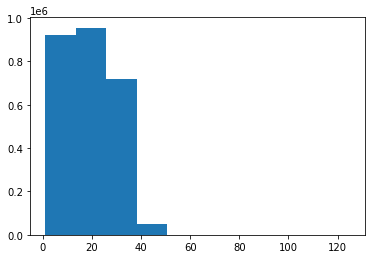

In [53]:
plt.hist(chryon_all['num_words'])

(array([475551.,      0.,      0., 775759.,      0.,      0., 685712.,
             0.,      0., 717324.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

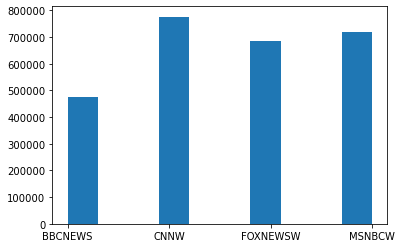

In [54]:
# distribution of entries per network

plt.hist(chryon_all['channel']);

In [57]:
chryon_all.channel.unique()

array(['BBCNEWS', 'CNNW', 'FOXNEWSW', 'MSNBCW'], dtype=object)

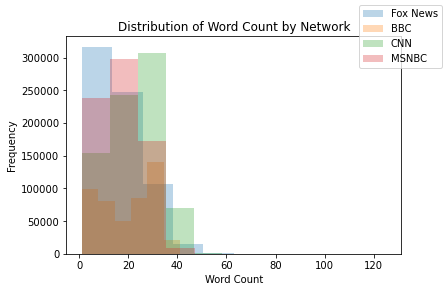

In [59]:
# distribution of word counts
fig, ax = plt.subplots()

fox = chryon_all[chryon_all['channel'] == 'FOXNEWSW']
bbc = chryon_all[chryon_all['channel'] == 'BBCNEWS']
cnn = chryon_all[chryon_all['channel'] == 'CNNW']
msnbc = chryon_all[chryon_all['channel'] == 'MSNBCW']

ax.hist(fox['num_words'], label='Fox News', alpha=0.3)
ax.hist(bbc['num_words'], label='BBC', alpha=0.3)
ax.hist(cnn['num_words'], label='CNN', alpha=0.3)
ax.hist(msnbc['num_words'], label='MSNBC', alpha=0.3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Word Count by Network')
fig.legend();

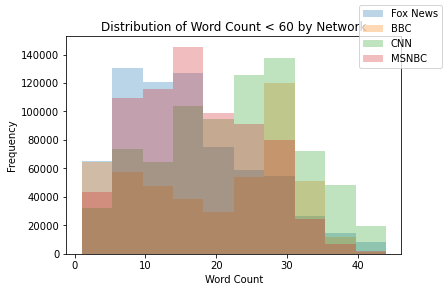

In [73]:
# distribution of word counts under 60
fig, ax = plt.subplots()

fox = chryon_all[(chryon_all['channel'] == 'FOXNEWSW') & (chryon_all['num_words'] < 60)]
bbc = chryon_all[(chryon_all['channel'] == 'BBCNEWS') & (chryon_all['num_words'] < 60)]
cnn = chryon_all[(chryon_all['channel'] == 'CNNW') & (chryon_all['num_words'] < 60)]
msnbc = chryon_all[(chryon_all['channel'] == 'MSNBCW') & (chryon_all['num_words'] < 60)]

ax.hist(fox['num_words'], label='Fox News', alpha=0.3)
ax.hist(bbc['num_words'], label='BBC', alpha=0.3)
ax.hist(cnn['num_words'], label='CNN', alpha=0.3)
ax.hist(msnbc['num_words'], label='MSNBC', alpha=0.3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Word Count < 60 by Network')
fig.legend();

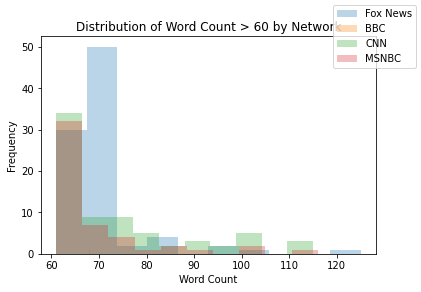

In [62]:
# distribution of word counts under 60
fig, ax = plt.subplots()

fox = chryon_all[(chryon_all['channel'] == 'FOXNEWSW') & (chryon_all['num_words'] > 60)]
bbc = chryon_all[(chryon_all['channel'] == 'BBCNEWS') & (chryon_all['num_words'] > 60)]
cnn = chryon_all[(chryon_all['channel'] == 'CNNW') & (chryon_all['num_words'] > 60)]
msnbc = chryon_all[(chryon_all['channel'] == 'MSNBCW') & (chryon_all['num_words'] > 60)]

ax.hist(fox['num_words'], label='Fox News', alpha=0.3)
ax.hist(bbc['num_words'], label='BBC', alpha=0.3)
ax.hist(cnn['num_words'], label='CNN', alpha=0.3)
ax.hist(msnbc['num_words'], label='MSNBC', alpha=0.3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Word Count > 60 by Network')
fig.legend();

In [2]:
# sklearn pipeline 

# english dictionary 
# eng_dict = words.words()

# get a random sample of chyrons
def get_random_sample(df, num_samples):
    idx_lst = [num for num in range(len(df))]
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

# get stop words
custom_stops = ['msnbc', 'nbc', 'nbc news', 'mssnbc news', 'fox', 'fox news', 
                'says', 'er', 'tn', 'ui', 'thf', 'thf', 'nm', 'ni', 'new', 'nl'
                'li', 'iu', 'ai', 'ul', 'wsntunnelztowersdrg', 'yingst', 'wnr'
                'irl', 'wopi', 'across', 'xeljanz']

def get_stop_words(words, custom_stops=custom_stops):
    sw = stopwords.words('english')
    stops = words[0]
    
    for lst in words[1:]:
        stops += lst

    stops = stops + custom_stops
    
    return sw + stops

## ------------------------------------------------------ ##

# sklearn count vectorizer
def get_countvec(corpus, stop_words='english', min_df=.01, n_grams=(1,1)):
    vectorizer = CountVectorizer(stop_words=stop_words, min_df=min_df, ngram_range=n_grams)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, X.toarray()

# sklearn tfidf vectorizer
def get_tfidf(corpus, max_features=None, min_df=.01, stop_words='english', n_grams=(1,1)):
    vectorizer = TfidfVectorizer(max_features=None, min_df=min_df, max_df=1.0, stop_words='english', ngram_range=n_grams)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, X.toarray()

# vectorizer to dataframe
def get_dataframe(X, feature_names):
    df = pd.DataFrame(data = X, columns = feature_names)
    return df

## ------------------------------------------------------ ##

# odd "word" functions
def get_numeric_words(feature_names):
    stops = set()
    nums = [str(num) for num in range(10)]
    
    for word in feature_names:
        for char in word:
            if char in nums:
                stops.add(word)
                break
                
    return list(stops)

def get_non_alpha_start(feature_names):
    non_alpha = []
    alpha = list(string.ascii_lowercase)
    for name in feature_names:
        if name[0] not in alpha:
            non_alpha.append(name)
            
    return non_alpha

def get_underscores(feature_names):
    unders = []
    for name in feature_names:
        if '_' in name:
            unders.append(name)
            
    return unders

def get_multis(feature_names):
    multi = []
    for name in feature_names:
        if len(name) == 2:
            if name[0] == name[1]:
                multi.append(name)
        else:
            search = re.search(r"([A-Za-z])\1\1", name)
            if search != None:
                multi.append(name)
                
    return multi

# wrap for above 
def get_special_stops(feature_names):
    numeric = get_numeric_words(feature_names)
    non_alpha = get_non_alpha_start(feature_names)
    unders = get_underscores(feature_names)
    multi_lett = get_multis(feature_names)
    
    return [numeric, non_alpha, unders, multi_lett]


## ------------------------------------------------------ ##

# PIPELINE:

def load_samps(num_samples):
    chyrons = pd.read_csv('/Users/jonleckie/Desktop/DSI_all/capstones/capstone_two/chyrons/chyron_all.csv') # read all data
    chyrons.drop(472372, inplace=True) # drop single NaN value
    chy_samp = get_random_sample(chyrons, num_samples) # random sample for working locally 
    
    return chy_samp
    
def clean_counts(chy_samp, min_df=.001, n_grams=(1,1)):
    count_features, chyron_counts = get_countvec(chy_samp['text'], stop_words='english', min_df=min_df, n_grams=n_grams) # get primary feature names
    stops = get_special_stops(count_features) # get additional stop words
    stop_words_plus = get_stop_words(stops) # add to nltk stop words
    count_features, chyron_counts = get_countvec(chy_samp['text'], stop_words=stop_words_plus, min_df=min_df, n_grams=n_grams) # get new vector matrix

    return count_features, chyron_counts

def clean_tfidf(chy_samp, min_df=.001, n_grams=(1,1)):
    tfidf_features, chyron_tfidf = get_tfidf(chy_samp['text'], max_features=None, min_df=min_df, stop_words='english', n_grams=n_grams) # get primary feature names
    stops = get_special_stops(tfidf_features) # get additional stop words
    stop_words_plus = get_stop_words(stops) # add to nltk stop words
    tfidf_features, chyron_tfidf = get_tfidf(chy_samp['text'], max_features=None, min_df=min_df, stop_words=stop_words_plus, n_grams=n_grams) # get new vector matrix

    return tfidf_features, chyron_tfidf


# limit data from summer 2020, MSNBC and Fox
def load_summer(start_date='2020-05-25', end_date='2020-11-03'):
    chyrons = pd.read_csv('chyron_all.csv')
    chyrons.drop(472372, inplace=True)
    chyrons = chyrons.replace(r'\\n',' ',regex=True)
    chyrons = chyrons.replace(r'\\u',' ',regex=True)
    chy_summer = chyrons.loc[(chyrons['date_time_(UTC)'] >= start_date) & (chyrons['date_time_(UTC)'] <= end_date)]
    
    return chy_summer

def get_network_pair(df, net_one='FOXNEWSW', net_two='MSNBCW'):
    chy_nets = df.loc[(df['channel'] == net_one) | (df['channel'] == net_two)]
    
    return chy_nets

## ------------------------------------------------------ ##

# for word frequency charting
def get_word_freq(df):
    series = df.sum()
    series = series.apply(lambda x: x/len(series))
    return series

def get_freq_df(fox, msnbc):
#     words = [word for words in fox.index] + [word for word in msnbc.index]
    shared_words = []
    freq = []
    diff = []
    
    for word in fox.index:
        if word in msnbc.index:
            shared_words.append(word)
            freq.append((fox[word], msnbc[word]))  
            diff.append(np.abs(fox[word] - msnbc[word]))
            
    freq_df = pd.DataFrame({'word': shared_words, 'fox_freq':[freq[0] for freq in freq],
                           'msnbc_freq': [freq[1] for freq in freq], 'difference': diff})
            
    return freq_df

def freq_df(fox_df, msnbc_df):
    fox_freq = get_word_freq(fox_df)
    msnbc_freq = get_word_freq(msnbc_df)
    df = get_freq_df(fox_freq, msnbc_freq)
    df.sort_values(by='difference', ascending=False, axis=0, inplace=True)
    
    return df

# chart consecutive word frequencies
def chart_freq_diff(df):
    fig, ax = plt.subplots()
    labels = df['word']
    fox = df['fox_freq']
    msnbc = df['msnbc_freq']
    
    x = np.arange(len(labels))
    width = 0.35
    fox_bar = ax.bar(x - width/2, fox, width, label='Fox News')
    msnbc_bar = ax.bar(x + width/2, msnbc, width, label='MSNBC')
    
    ax.set_ylabel('Frequency')
    ax.set_title('Word Use Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout();

# chart by choice of words
def chart_word_diff(df, word_lst):
    fig, ax = plt.subplots()
    labels = word_lst
    df_ = df.set_index('word')
    fox = df_.loc[word_lst, 'fox_freq']
    msnbc = df_.loc[word_lst, 'msnbc_freq']
    
    x = np.arange(len(labels))
    width = 0.35
    fox_bar = ax.bar(x - width/2, fox, width, label='Fox News')
    msnbc_bar = ax.bar(x + width/2, msnbc, width, label='MSNBC')
    
    ax.set_ylabel('Frequency')
    ax.set_title('Word Use Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout();

In [35]:
# chy_summer = load_summer()

In [3]:
chy_summer = load_summer()

chy_nets = get_network_pair(chy_summer, net_one='FOXNEWSW', net_two='MSNBCW')
feature_count, count_vec = clean_counts(chy_nets, n_grams=(1,2))

fox_features, fox_counts = clean_counts(chy_nets.loc[chy_nets['channel'] == 'FOXNEWSW'], n_grams=(1,2))
msnbc_features, msnbc_counts = clean_counts(chy_nets.loc[chy_nets['channel'] == 'MSNBCW'], n_grams=(1,2))
fox_df = get_dataframe(fox_counts, fox_features)
msnbc_df = get_dataframe(msnbc_counts, msnbc_features)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['age', 'angi', 'anon', 'associated', 'biden', 'bravest', 'campaign', 'cases', 'com', 'covid', 'covld', 'death', 'deaths', 'election', 'floyd', 'id', 'ilem', 'ill', 'july', 'li', 'lin', 'mo', 'mssnbc', 'news', 'pandemic', 'prfslnfntiai', 'race', 'relief', 'response', 'trump', 'vaccine'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['angi', 'anon', 'biden', 'bravest', 'campaign', 'cases', 'com', 'covid', 'covld', 'democracy', 'devi', 'donate', 'election', 'ft', 'hands', 'ia', 'id', 'ill', 'inn', 'li', 'lia', 'lin', 'mo', 'month', 'mssnbc', 'nearly', 'news', 'nnlrl'

In [4]:
df = freq_df(fox_df, msnbc_df)

In [5]:
df

,word,fox_freq,msnbc_freq,difference
1279,trump,11.981660,20.695913,8.714253
1354,virus,0.290058,3.092238,2.802181
179,cases,0.610039,3.356580,2.746542
938,president trump,3.138514,0.554181,2.584333
937,president,4.137548,1.674541,2.463008
935,pres,0.114865,2.163855,2.048990
936,pres trump,0.074807,1.923885,1.849078
267,covid,1.836390,3.529434,1.693044
450,fmr,0.363417,1.310461,0.947044
905,police,3.456564,2.543682,0.912882


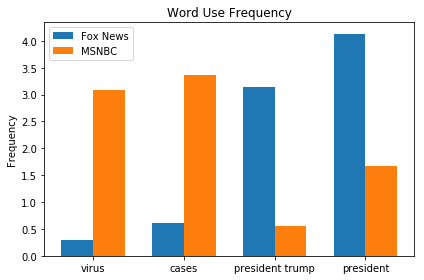

In [6]:
chart_freq_diff(df[1:5])

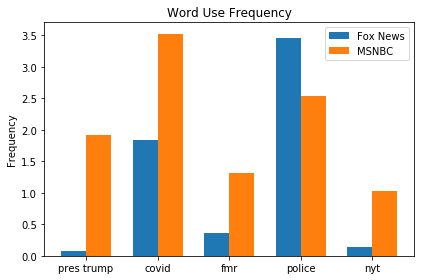

In [159]:
chart_freq_diff(df[6:11])

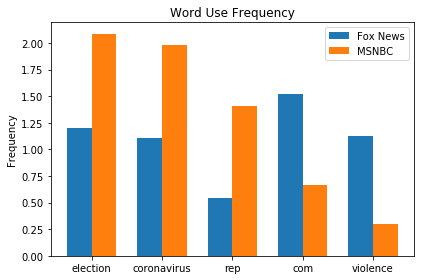

In [160]:
chart_freq_diff(df[12:17])

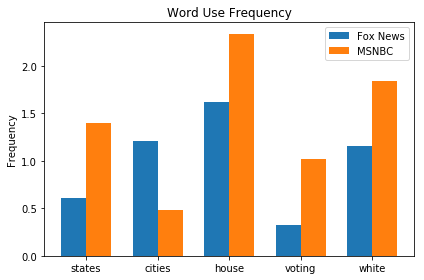

In [161]:
chart_freq_diff(df[18:23])

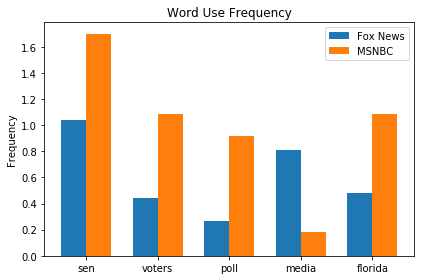

In [162]:
chart_freq_diff(df[24:29])

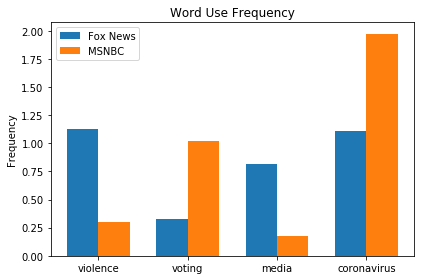

In [39]:
chart_word_diff(df, ['violence', 'voting', 'media', 'coronavirus'])

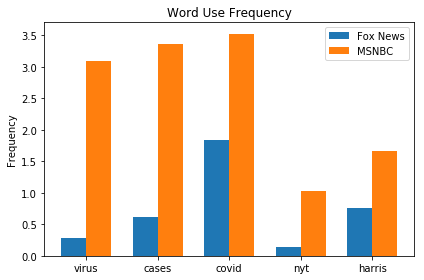

In [7]:
chart_word_diff(df,['virus', 'cases', 'covid', 'nyt', 'harris'])

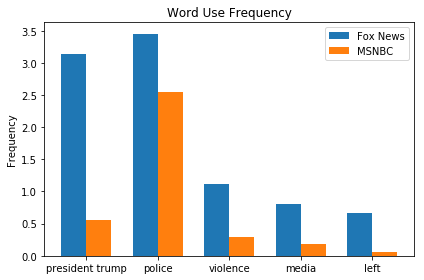

In [10]:
chart_word_diff(df,['president trump', 'police', 'violence', 'media', 'left'])

In [5]:
count_vec.shape, tfidf_vec.shape, tri_vec.shape

((182424, 2343), (182424, 2406), (182424, 2415))

In [21]:
tfidf_vec.shape

(182424, 2406)

In [48]:
y.value_counts()

MSNBCW      102271
FOXNEWSW     80153
Name: channel, dtype: int64

In [49]:
102271/182424, 80153/182424

(0.560622505810639, 0.43937749418936106)

### Setting Up X and y, TT_split

In [54]:
chy_summer[chy_summer['text'] == "FIRED MINNEAPOLIS OFFICER INVOLVED IN FLOYD'S DEATH ARRESTED"]

,Unnamed: 0,Unnamed: 0.1,date_time_(UTC),channel,duration,https://archive.org/details/,text,num_words


In [110]:
# X, y for original random sample 

# doc_freq = .2

# chy_samps = load_samps(num_samples=250000)
# count_features, chyron_counts = clean_counts(chy_samps, min_df=doc_freq)
# tfidf_features, chyron_tfidf = clean_tfidf(chy_samps, min_df=doc_freq)

# X_counts = get_dataframe(chyron_counts, count_features)
# X_tfidf = get_dataframe(chyron_tfidf, tfidf_features)
# y = chy_samps['channel']

In [6]:
# X, y for summer tests on Fox and MSNBC
X_counts = get_dataframe(count_vec, feature_count)
# X_tfidf = get_dataframe(tfidf_vec, feature_tfidf)
# X_three = get_dataframe(tri_vec, tri_feature)
y = chy_nets['channel']

# first split:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, 
                                                    train_size=0.33, 
                                                    shuffle=True, stratify=y)

# X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(X_tfidf, y, 
#                                                             train_size=0.33, 
#                                                             shuffle=True, stratify=y)

# X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_three, y, 
#                                                             train_size=0.33, 
#                                                             shuffle=True, stratify=y)

In [7]:
len(X_counts), len(X_tfidf), len(y)

(182424, 182424, 182424)

In [8]:
X_counts.shape, X_tfidf.shape, X_three.shape

((182424, 2343), (182424, 2406), (182424, 2415))

### models.py

In [7]:
# Naive Bayes

def eval_naive_bayes(X, y, folds=20, fit_prior=False):
    y_net = pd.Series([1 if net == 'MSNBCW' else 0 for net in y]) #MSNBC = postive class
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    
    for train, test in kf.split(X):
        model = MultinomialNB(alpha=1, fit_prior=fit_prior)
        model.fit(X.iloc[train], y_net.iloc[train])
        accuracy.append(model.score(X.iloc[test], y_net.iloc[test]))
    
    return model, np.mean(accuracy)

def test_folds(X, y, fold_lst):
    accuracy = []
    iters = 0
    for folds in fold_lst:
        print(iters)
        model, score = eval_naive_bayes(X, y, folds=folds)
        accuracy.append(score)
        
        iters += 1
        
    return accuracy

def plot_naive_bayes(X, y, fold_lst):
    fig, ax = plt.subplots()
    xs = fold_lst
    ys = test_folds(X, y, fold_lst)
    ax.plot(xs, ys)
    ax.set_title('Naive Bayes Accuracy by Num_Folds')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Folds');


# ROC Curve
def plot_roc(X, y, vec_type='Count'):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y_net, train_size=0.33, shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_hat[:, 1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_title(f'Naive Bayes ROC Curve {vec_type}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return thresh

# Random Forest
def eval_random_forest(X, y, folds=10, n_estimators=100, max_depth=5, max_leaf=None, max_features='log2'):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    oob = []
    iters = 0
    
    for train, test in kf.split(X):
        forest = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, n_jobs=-1, 
                                        max_leaf_nodes=max_leaf, max_features=max_features, 
                                        oob_score=True)
        forest.fit(X.iloc[train], y.iloc[train])
        accuracy.append(forest.score(X.iloc[test], y.iloc[test]))
        oob.append(forest.oob_score_)
        
        print(iters)
        iters += 1
    
    return np.mean(accuracy), np.mean(oob), forest

def test_forest_folds(X, y, fold_lst):
    accuracy = []
    for folds in fold_lst:
        accuracy.append(eval_random_forest(X, y, folds=folds))
        
    return accuracy

def test_forest_depth(X, y, depth_lst):
    accuracy = []
    for depth in depth_lst:
        accuracy.append(eval_random_forest(X, y, max_depth=depth))
        
    return accuracy

def test_forest_estimators(X, y, est_lst):
    accuracy = []
    for est in est_lst:
        accuracy.append(eval_random_forest(X, y, n_estimators=est, max_depth=50))
        
    return accuracy

def test_max_leafs(X, y, leaf_lst):
    accuracy = []
    for leaf in leaf_lst:
        accuracy.append(eval_random_forest(X, y, max_leaf=leaf))
        
    return accuracy

def plot_folds_random_forest_folds(X, y, fold_lst):
    fig, ax = plt.subplots()
    xs = fold_lst
    ys = test_forest_folds(X, y, fold_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Folds')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Folds');
    
def plot_depth_random_forest(X, y, depth_lst):
    fig, ax = plt.subplots()
    xs = depth_lst
    ys = test_forest_depth(X, y, depth_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Depth')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Depth');

# ROC Curve
def plot_roc_forest(X, y, vec_type='(Count)', max_depth=10):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y_net, train_size=0.33, shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = RandomForestClassifier(max_depth=max_depth, max_features='log2', n_jobs=-1)
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_hat[:,1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_title(f'Random Forest ROC Curve {vec_type}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return thresh

# feature importances
# gini
def chart_gini_import(model, X, size=15, figsize=(10,4)):
    fig, ax = plt.subplots()
    feature_scores = pd.Series(model.feature_importances_, index=X.columns)
    feature_scores = feature_scores.sort_values()
    ax = feature_scores[-size:].plot(kind='barh', figsize=figsize)
    ax.set_title('Gini Importance')
    ax.set_xlabel('Avg. Contribution to Info Gain');

# permutations
def chart_permutation_import(model, X, y, size=15, n_repeats=5):
    fig, ax = plt.subplots()
    perms = permutation_importance(model, X, y, n_repeats=n_repeats)
    sorted_idx = perms.importances_mean.argsort()
    ax.boxplot(perms.importances[sorted_idx[:size]].T, vert=False, labels=X.columns[sorted_idx])
    ax.set_title('Permutation Importance');


# other charting functions:
# top words
def chart_top(word_lst, network, low=0, high=10,):
    fig, ax = plt.subplots(figsize=(10,4))
    
    ax.barh(word_lst.index[low:high], word_lst.values[low:high], align='center')
    ax.invert_yaxis()
    ax.set_title(f'Top Word Counts: {network}')
    ax.set_ylabel('Words')
    ax.set_xlabel('Counts');

# shared words (network word counts against each other)
def chart_shared_word_counts(thresh=20000):
    fig, ax = plt.subplots()
    nbc_lt = []
    fox_lt = []
    words = []
    
    for i, word in enumerate(nbc_word_counts):
        if word < thresh:
            nbc_lt.append(nbc_word_counts[i])
            fox_lt.append(fox_word_counts[i])
        
    ax.scatter(nbc_lt, fox_lt, alpha=0.3)
    ax.set_title('Shared Word Counts by Network')
    ax.set_xlabel('MSNBC')
    ax.set_ylabel('Fox News');

## Naive Bayes Models with N-Grams

In [298]:
# with n-grams=(1,2)
bayes, accuracy = eval_naive_bayes(X_test, y_test, folds=20)
print(accuracy) #--> 10_folds = 0.7762486128041685 -- 20_folds = 0.7766414308139731

0.7766414308139731


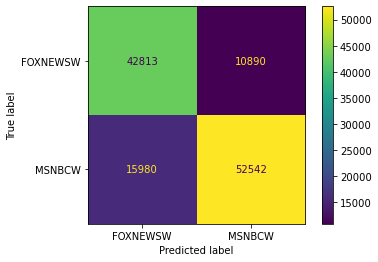

In [296]:
# confustion matrix with n-grams=(1,2), folds = 10
plot_confusion_matrix(bayes, X_test, y_test)  
plt.show()

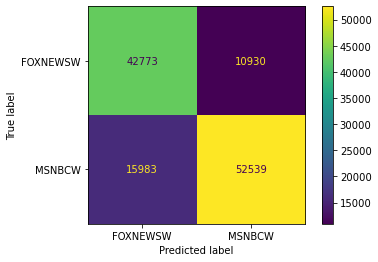

In [299]:
# confustion matrix with n-grams=(1,2), folds = 20
plot_confusion_matrix(bayes, X_test, y_test)  
plt.show()

array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       7.70207573e-21, 6.06538464e-21, 1.59413368e-26])

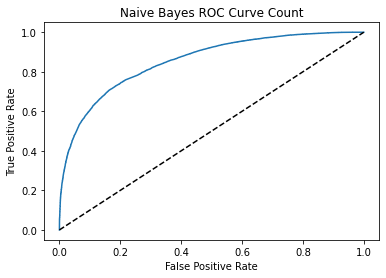

In [297]:
# roc curve with n-grams=(1,2), folds = 10
plot_roc(X_train, y_train)

0
1
2


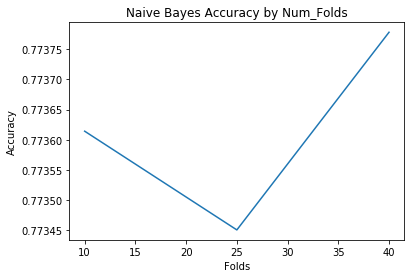

In [10]:
fold_lst = [10, 25, 40]

plot_naive_bayes(X_test, y_test, fold_lst)

0
1
2


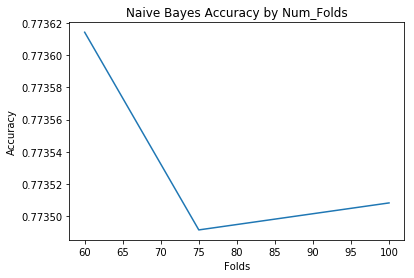

In [11]:
fold_lst = [60, 75, 100]

plot_naive_bayes(X_test, y_test, fold_lst)

In [37]:
# with og stop words
bayes, accuracy = eval_naive_bayes(X_test, y_test, folds=20)
print(accuracy)

0.7752015023547788


In [197]:
# with better stop words
bayes, accuracy = eval_naive_bayes(X_test, y_test, folds=20)
print(accuracy)

0.7700469127104073


In [35]:
type(y_test)

pandas.core.series.Series

In [10]:
bayes, accuracy = eval_naive_bayes(X_test_3, y_test_3, folds=20)
print(accuracy)

0.7758888290769972


In [10]:
bayes, accuracy = eval_naive_bayes(X_test, y_test, folds=20)
print(accuracy)

0.7706360384265437


In [8]:
# for presentation
bayes, accuracy = eval_naive_bayes(X_test, y_test, folds=20)
print(accuracy)

0.7703169858918903


array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       2.67658201e-26, 2.97857519e-28, 1.67860882e-28])

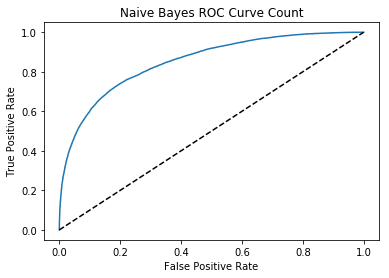

In [9]:
# for presentation
plot_roc(X_test, y_test)

In [221]:
def sort_probs(model, X, y):
#     words = X.columns
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    probs = model.predict_proba(X)
    df = pd.DataFrame(probs)
    df['net'] = y_net
    df['index'] = X.index
#     df['doc'] = chy_summer['text'].iloc[X.index]
#     df['word'] = words
    msnbc = df.loc[df['net'] == 1]
    fox = df.loc[df['net'] == 0]
#     msnbc = msnbc.sort_values(by='1', axis=1, ascending=False)
#     fox = fox.sort_values(by='0', axis=1, ascending=False)
    return msnbc, fox

In [40]:
def sort_probs(model, X, y):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    probs = model.predict_proba(X)
    df = pd.DataFrame(probs)
    df['net'] = y_net
    df['index'] = X.index
    msnbc = df.loc[df['net'] == 1]
    fox = df.loc[df['net'] == 0]

    return msnbc, fox

msnbc, fox = sort_probs(bayes, X_train, y_train)

def sort_chyrons(msnbc, fox):
    sorted_ms = []
    sorted_fox = []
    ms_sort = msnbc.sort_values(by=1)
    fox_sort = fox.sort_values(by=1)

    for i in ms_sort['index']:
        sorted_ms.append(chy_summer.iloc[i, 6])

    for i in fox_sort['index']:
        sorted_fox.append(chy_summer.iloc[i, 6])
    
    return sorted_fox, sorted_ms

In [41]:
msnbc, fox = sort_probs(bayes, X_train, y_train)
fox_chys, ms_chys = sort_chyrons(msnbc, fox)

In [47]:
fox_chys[11:17]

["GOYA CEO SAYS HE WON'T APOLOGIZE AFI'ER HIS. PRAISE OF TRUMP SPARKS CALLS FOR BOYCOTI' Ana Navarro I (Ml Political Commentator",
 'Whm fb02mwm mummm mammlm',
 'DR. ANTHONY FAUCI DISCUSSES CORONAVIRUS SURGE WITH CNN FAUCI:  201cWE\'RE SEEING THE CONSEQUENCES OF COMMUNITY. SPREAD WHICH IS EVEN MORE DIFFICULT TO CONTAIN\\" FAUCI \\"CAUTIOUSLY OPTIMISTIC\\" ON...',
 'lIFE IN CHOP: MORE WEAPONS & MORE COMPLAINTS RANTZ: CHOP HAS GROWN TO BE MORE DANGEROUS',
 'NUW UI 2019IZN. . mm',
 "ASTRONAUTS TO BE TRANSPORTED TO RETURN TO '. LAUNEH PAD IN TESLA MODEL X. . ' 2014_ ASTRONAUTS WALK our OF NEIL. QPERATIONS AND CHECKOUT fb01mgmgNG RESTPMTD '5. . ' 2014 2014"]

In [46]:
ms_chys[11:17]

['INDOOR DINING POSTPONED',
 'I TRUMP SILENT AFIER SENATE PASSES BILL TO PUNISH CHINA I WILSON CENTER. I JAN E HARMAN DIRECTOR, PRESIDENT, AND CEO',
 "JUNEI'EENTH CELEBRATIONS CALL FOR RACIAL EQUALITY",
 'TRUMP TO HOLD FIRST CAMPAIGN RALLY AMID PANDEMIC NEXT SATURDAY TRUMP TO HOLD FIRST CAMPAIGN RALLY AMID PANDEMIC NEXT SATURDAY. . David Axelrod Former Senior Adviser to President Obama TRUMP TO HOLD...',
 "U 18 IOUI'ISIS Pa131ey nat nre",
 'AP: MINNEAPOLIS AGREES TO BAN ALL CHOKEHOLDS BY POLICE']

In [28]:
probs = bayes.predict_proba(X_train)

In [29]:
probs[22]

array([0.25158769, 0.74841231])

In [226]:
sorted_ms_chy = []
ms_sort = msnbc.sort_values(by=1)
for i in ms_sort['index']:
    sorted_ms_chy.append(chy_summer.iloc[i, 6])
    
sorted_ms_chy[:5]

['NEW LOUISVILLE LAW WOULD CHANGE BODY CAMERA. POLICY AFI\'ER BREONNA TAYLOR KILLED IN OWN HOME LOUISVILLE MOVES ONE STEP CLOSER TO PASSING \\"BREONNA 2019S LAW\\',
 'DOZENS OF PROTESTERS ARRESTED IN NEW YORK CITY 2 OFFICERS SHQT, I STABBED IN NEW YORK CITY NYPD OFFICER BAS fb01HED IN HEAD WITH FIRE EXTINGUISHER PEACEFUL PROTESTS SEEN ACROSS NEW...',
 'TOP U.S. GENERAL: APPEARING IN TRUMP BIBLE PHOTO-OP A \\"MISTAKE\\" TRUMP TO REQUIRE RALLY ATTENDEES TO SIGN CORONAVIRUS WAIVER',
 'HE]. NEWS Lib Dem. Orkney and Shetland. -',
 '\\"JANE DOE\\" ACCUSES GHISLAINE MAXWELL OF RAPE GHISLAINE MAXWELL DENIES ALLEGATIONS OF SEX ABUSE']

In [227]:
sorted_fox_chy = []
fox_sort = fox.sort_values(by=1)
for i in fox_sort['index']:
    sorted_fox_chy.append(chy_summer.iloc[i, 6])
    
sorted_fox_chy[:5]

["FIRED MINNEAPOLIS OFFICER INVOLVED IN FLOYD'S DEATH ARRESTED OFFICER WHO KNELT ON GEORGE FLOYD TAKEN INTO CUSTODY OFFICER WHO KNELT ON GEORGE FLOYD TAKEN INTO CUSTODY. . Laura Coates Former...",
 "LIHLL I'OUU'OO I'OOOC 'emc PureWick. . :Lern. . . . Urlne",
 "WEST POINT GRADUATE REACTS TO TRUMP'S MESSAGE TRUMP ADDRESSES GRADUATES AT WEST POINT",
 'DIUEN LALLD I\'UK PULIU: KEI\'UKI\'I I\'KUN LUNUKEDD DIUEN bALLD I\'UK PULIU: KEI\'UKIVI I\'KUIVI LUNUKED; \\"\'\\"\\\\\'= \\"\'=\\"\'V\'-\' | CORRESPONDENT',
 'O Daily Cases . Yrday moving average. . SOURCE: WI] RLDIJMETERSJNFEI O Daily beams + 7-day moving average. . SOURCE: WIJRLDIJMETERSJNFD']

In [212]:
for i in X_test.index[:5]:
    print(chy_summer.iloc[i, 6])

CITIES NATIONWIDE FACE ANOTHER NIGHT OF CURFEWS
NBC: NEARLY HALF THE EMPLOYEES AT AN ARIZONA ICE DETENTION. CENTER HAVE TESTED POSITIVE FOR COVID-19 I BY JULIA AINSLEY
I MOST GOP GOVERNORS FOLLOW TRUMP'S LEAD ON CORONAVIRUS ' I STEVE BENEN AUTHOR, \"THE IMPOSTORS\
ATlAIITK (UUMCIL U.S. REPORTS MORE THAN 3 MILLION CASES
Coronavirus in India. Of fb01cial tally of cases stands at nearly 7OO,OOO Coronavirus in India. More (han 19,OOO deaths have been recorded Coronavirus in India. India has third-highest number of cases...


In [195]:
X_test.iloc[2096, :]
chy_summer.iloc[2096, 6]

'TRUMP MARKS MEMORIAL DAY AS VIRUS DEATHS NEAR 1OO,OOO IN U.S. TRUMP MARKS MEMORIAL DAY AS VIRUS DEATHS NEAR 1OO OOO IN U.S.. . Jeremy Diamond G\\\\N White House Correspondent'

In [82]:
sort_probs(bayes, X_test, y_test)

KeyError: "None of [Int64Index([171153,  91084, 142193, 104300, 144317, 110583,  80889,  63612,\n            153184,  87014,\n            ...\n            160648,  28769,  77280, 175092,  99271, 154368,  44667, 118364,\n             94122, 169443],\n           dtype='int64', length=122225)] are in the [index]"

In [80]:
for i in X_test.index[:5]:
    print(chy_nets['text'].iloc[i])

BIDEN VOWS TO RELEASE POSITION ON COURT-PACKING. BEFORE ELECTION BASED ON BARRETI' VOTE
MAYOR OF JACKSON, MS ISSUES CURFEW. TO COMBAT RISING CIJVID-19 NUMBERS\nU.S. REPURTS MORE THAN 2.OOO NEW COVIIJ-19 DEATHS. IN A DAY FOR THE FIRST TIME SINCE MAY\nMORE THAN 161K AMERICANS HAVE DIED FROM...
SENATE GOP CUT SCOTUS TO EIGHT JUSTICES FOR OVER A YEAR\nMCCONNELL CUT SCOTUS TO 8 JUSTICES TO THWART OBAMA\nLIBERALS DEMAND SCHUMER PLAY HARDBALL ON SCOTUS
~\ufb01roxuaws DEMOCRACY 2O2O. \u2014'\narroxusws DEMOCRACY 2O2O. \u2014'\n.Woxuaws DEMOCRACY 2O2O\u2019 \u2014'
KY ATTORNEY GENERAL: OFFICERS WERE JUSTIFIED. IN USE OF FORCE IN BREONNA TAYLOR CASE


In [58]:
chy_nets.shape

(182424, 8)

In [68]:
chy_nets.[171153, :]

KeyError: 171153

In [41]:
neg_class_prob_sorted = bayes.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = bayes.feature_log_prob_[1, :].argsort()[::-1]
neg_words = np.take(feature_count, neg_class_prob_sorted[:25])
pos_words = np.take(feature_count, pos_class_prob_sorted[:25])

In [42]:
neg_words #fox

array(['trump', 'biden', 'president', 'police', 'president trump', 'new',
       'covid', 'protests', 'court', 'news', 'house', 'com', 'ntrump',
       'fox', 'campaign', 'cities', 'ni', 'election', 'debate',
       'violence', 'supreme', 'floyd', 'supreme court', 'coronavirus',
       'white'], dtype='<U21')

In [43]:
pos_words #msnbc

array(['trump', 'biden', 'ntrump', 'covid', 'cases', 'new', 'virus',
       'police', 'house', 'election', 'says', 'coronavirus', 'protests',
       'white', 'ni', 'floyd', 'campaign', 'pres', 'harris', 'president',
       'death', 'states', 'white house', 'news', 'pres trump'],
      dtype='<U21')

## Random Forest Models with N-Grams

In [46]:
# with bi-grams
accuracy_rf, oob, forest = eval_random_forest(X_train, y_train, folds=10, n_estimators=100, 
                                         max_depth=100, max_leaf=None, max_features='log2')
print(accuracy_rf) # --> 0.8116246835188019

0
1
2
3
4
5
6
7
8
9
0.8120899377883657


In [ ]:
plot_confusion_matrix(forest, X_train, y_train)  
plt.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([2.        , 1.        , 0.99795918, ..., 0.0105802 , 0.00454545,
       0.        ])

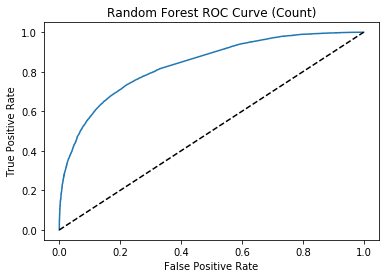

In [41]:
plot_roc_forest(X_train, y_train, vec_type='(Count)', max_depth=90)

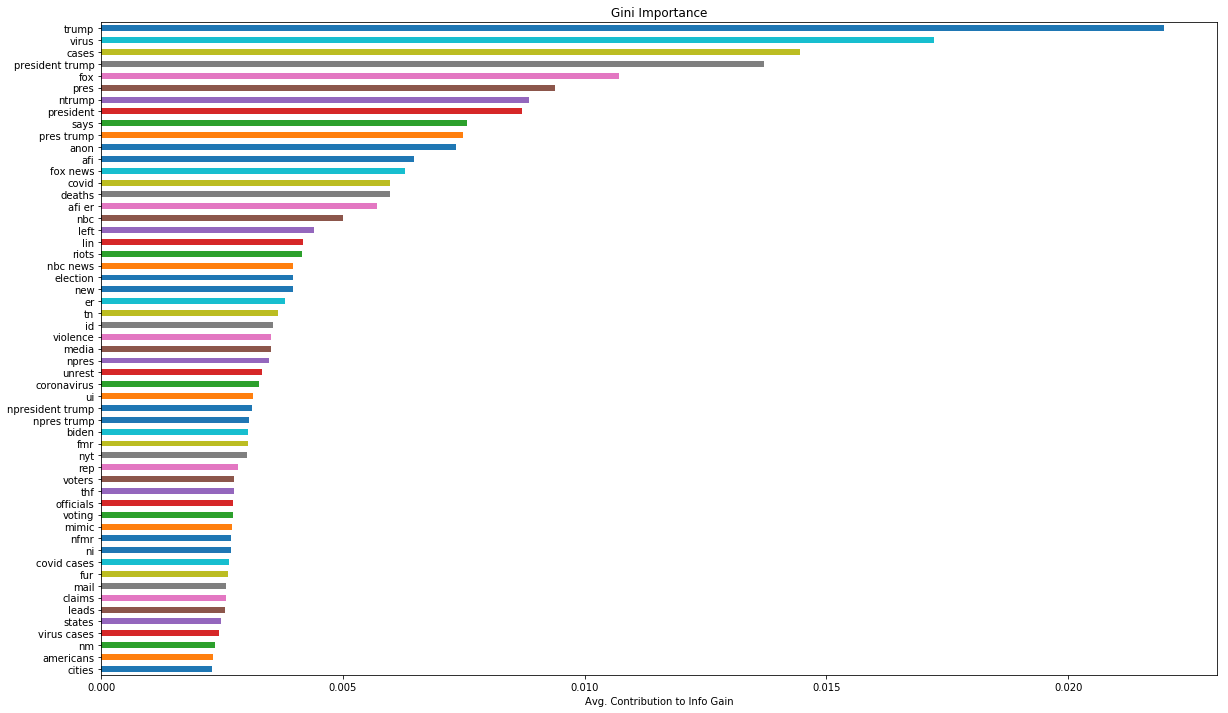

In [47]:
chart_gini_import(forest, X_train, size=55, figsize=(20,12))

In [54]:
accuracy_rf, oob, forest = eval_random_forest(X_train, y_train, folds=10, n_estimators=500, 
                                         max_depth=100, max_leaf=None, max_features='log2')
print(accuracy_rf) # --> 0.8116246835188019

0
1
2
3
4
5
6
7
8
9
0.8149969559296999


In [ ]:
est_lst = [10, 25, 50, 100, 500, 1000]
leaf_lst = [50, 100, 1000]
depth_lst = [150, 200]

estimators = test_forest_estimators(X_train, y_train, est_lst)
leaf = test_max_leafs(X_train, y_train, leaf_lst)
test_forest_depth(X_train, y_train, depth_lst)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1
2
3
4
5


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6
7


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


8


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1


In [ ]:
leaf_lst = [50, 100, 1000]
depth_lst = [150, 200]

estimators = test_forest_estimators(X_train, y_train, est_lst)
leaf = test_max_leafs(X_train, y_train, leaf_lst)
test_forest_depth(X_train, y_train, depth_lst)

In [16]:
depth_lst = [150, 200]

depth = test_forest_depth(X_train, y_train, depth_lst)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [17]:
depth

[(0.8281035166049481,
  0.8213499349336327,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=150, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
              oob_score=True, random_state=None, verbose=0, warm_start=False)),
 (0.8339008284397306,
  0.8281477551774546,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=200, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
              oob_score=True, random_state=None, verbose=0, warm_start=False))]

In [15]:
leaf

[(0.5634975898580299,
  0.5665745651057519,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=5, max_features='log2', max_leaf_nodes=50,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
              oob_score=True, random_state=None, verbose=0, warm_start=False)),
 (0.5629993641398031,
  0.5658491896939987,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=5, max_features='log2', max_leaf_nodes=100,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
              oob_score=True, random_state=None, verbose=0, warm_start=False)),
 (0.5623516119221579,
  0.5656720026082007,
  RandomForestClassifier(boot

In [24]:
# with tri-grams
acc_rf_3, oob_3, forest_3 = eval_random_forest(X_train_3, y_train_3, folds=10, n_estimators=100, 
                                         max_depth=100, max_leaf=None, max_features='log2')
print(acc_rf_3) # 0.8102460315313798

0
1
2
3
4
5
6
7
8
9
0.8102460315313798


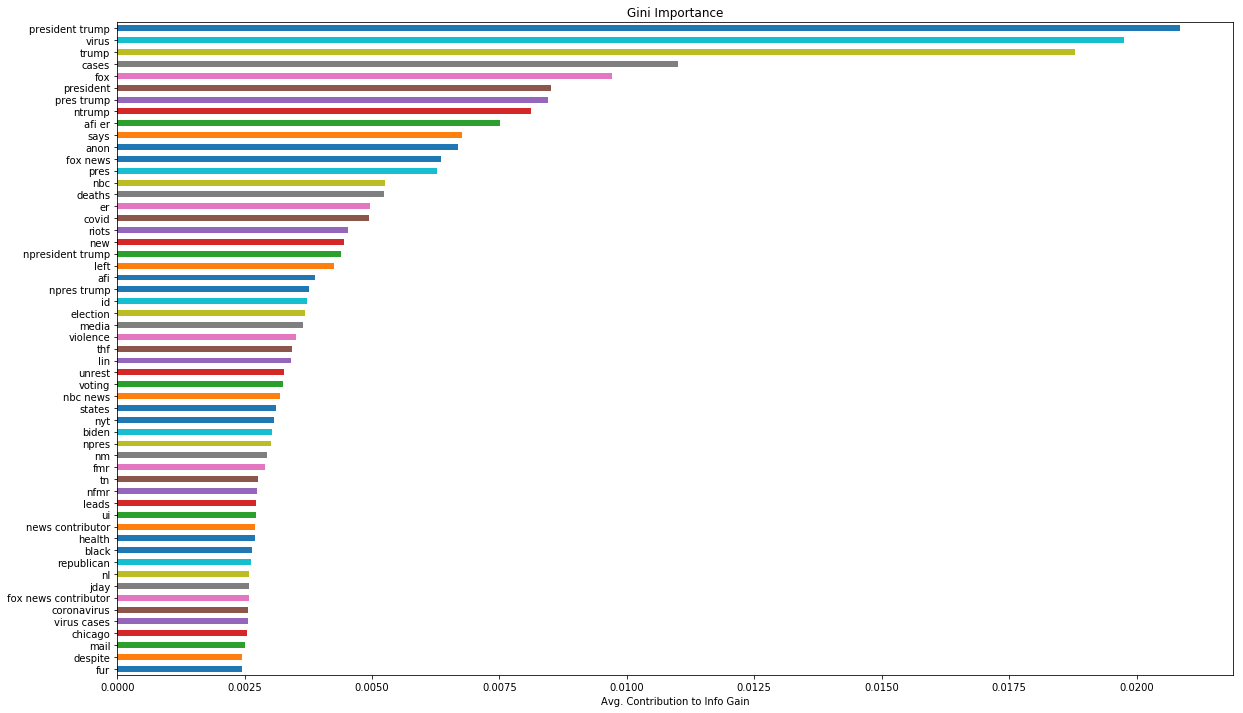

In [44]:
# with tri-grams
chart_gini_import(forest_3, X_train_3, size=55, figsize=(20,12))

In [17]:
forest_3.feature_importances_.shape, X_train_3.shape

((2343,), (60199, 2415))

In [53]:
n_begin = []
for i, word in enumerate(X_train.columns):
    if word[0] == 'n':
        n_begin.append(word)

In [50]:
n_begin

['na',
 'nag',
 'nag barr',
 'name',
 'names',
 'nan',
 'nancy',
 'nancy pelosi',
 'narizona',
 'nasa',
 'nascar',
 'nat',
 'nation',
 'national',
 'national convention',
 'national guard',
 'national security',
 'nationally',
 'nationwide',
 'nationwide protests',
 'natl',
 'natlanta',
 'nb',
 'nba',
 'nbarr',
 'nbc',
 'nbc news',
 'nbiden',
 'nbiden campaign',
 'nbiden harris',
 'nbiden leads',
 'nbiden trump',
 'nbill',
 'nbolton',
 'nc',
 'ncalls',
 'ncdc',
 'ncivil',
 'ncivil rights',
 'ncoronavirus',
 'ncovid',
 'nd',
 'ndavid',
 'ndemocrats',
 'ndems',
 'ndr',
 'ndr fauci',
 'ne',
 'near',
 'nearly',
 'nears',
 'need',
 'needs',
 'negative',
 'negotiations',
 'nem',
 'nevada',
 'never',
 'new',
 'new book',
 'new cases',
 'new coronavirus',
 'new covid',
 'new jersey',
 'new poll',
 'new virus',
 'new york',
 'news',
 'news conference',
 'news contributor',
 'nex',
 'next',
 'next week',
 'nf',
 'nfauci',
 'nfbi',
 'nfederal',
 'nfirst',
 'nfl',
 'nflorida',
 'nfmr',
 'nformer',

In [ ]:
# Bayes fold test with CountVec
folds = list(range(5, 100, 5))
plot_naive_bayes(X_train, y_train, folds)

In [ ]:
eval_naive_bayes(X_train_T, y_train_T, folds=100)

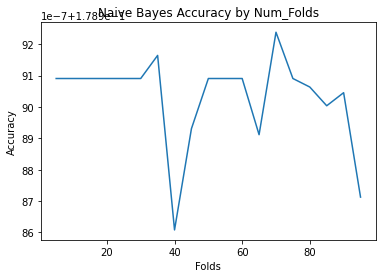

In [122]:
# Bayes fold test with TfidfVec
folds = list(range(5, 100, 5))
plot_naive_bayes(X_train_T, y_train_T, folds)

In [72]:
def _naive_bayes(X, y, folds=20, fit_prior=False):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    
    for train, test in kf.split(X):
        model = MultinomialNB(alpha=1, fit_prior=fit_prior)
        model.fit(X.iloc[train], y.iloc[train])
        accuracy.append(model.score(X.iloc[test], y.iloc[test]))
    
    return model, np.mean(accuracy)

In [118]:
y_hat, _y_test, model = _naive_bayes(X_train, y_train)

In [120]:
correct = 0
for i in range(len(y_hat)):
    if y_hat[i] == _y_test[i]:
        correct += 1
        
correct / len(_y_test)

0.1789090909090909

In [91]:
len(X_test), len(y_test)

(167500, 20625)

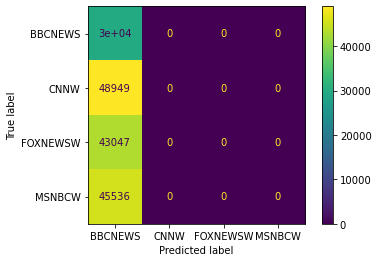

In [121]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [96]:
d = {}
for elem in y_test:
    if elem not in d:
        d[elem] = 1
    d[elem] += 1

In [100]:
for k, v in d.items():
    print(f'{k}:{v} --> {round(v/sum(d.values()), 4) * 100}%')

MSNBCW:45104 --> 26.93%
BBCNEWS:30376 --> 18.13%
CNNW:48954 --> 29.23%
FOXNEWSW:43070 --> 25.71%


In [128]:
T_y_hat, T_y_test, T_model, T_accuracy = _naive_bayes(X_train_T, y_train_T)

0.1789093825427889


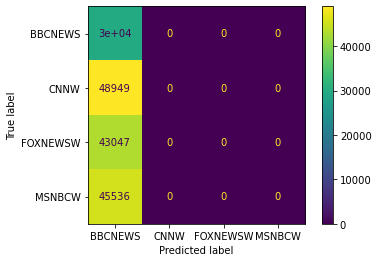

In [129]:
print(T_accuracy)
plot_confusion_matrix(T_model, X_test_T, y_test_T)  
plt.show()

##### With only summer for MSNBC/Fox

In [213]:
model, score = _naive_bayes(X_train, y_train)

In [214]:
score

0.7709763511238158

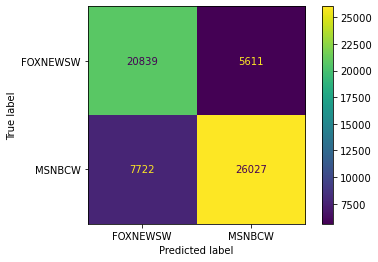

In [215]:
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

0.7709265227573094


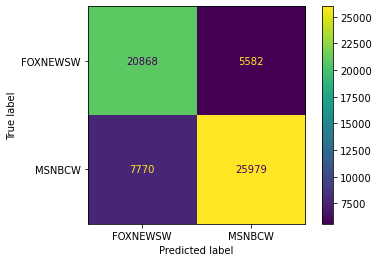

In [15]:
model, score = _naive_bayes(X_train, y_train)
print(score)
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [ ]:
folds = list(range(5, 20, 5))
plot_naive_bayes(X_train, y_train, folds)

0.7662751446656708


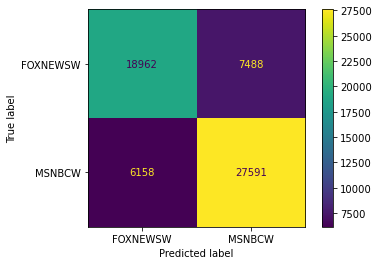

In [28]:
model, score = _naive_bayes(X_train, y_train, fit_prior=True)
print(score)
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [260]:
def plot_roc(X, y, vec_type='Count'):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y_net, train_size=0.33, shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_hat[:, 1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_title(f'Naive Bayes ROC Curve {vec_type}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return thresh

array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       4.64578677e-13, 3.10342080e-13, 6.22990360e-16])

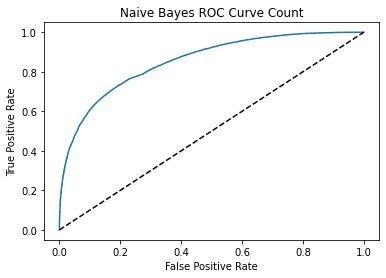

In [70]:
plot_roc(X_train, y_train)

0.7927873301468794


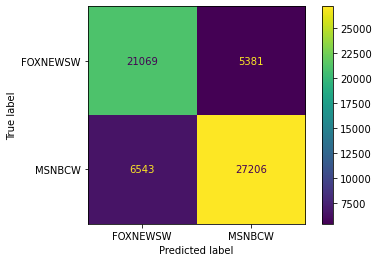

In [74]:
model, score = _naive_bayes(X_train_T, y_train_T, fit_prior=False)
print(score)
plot_confusion_matrix(model, X_train_T, y_train_T)  
plt.show()

array([1.99926543, 0.99926543, 0.98920947, ..., 0.00881591, 0.00877571,
       0.00290312])

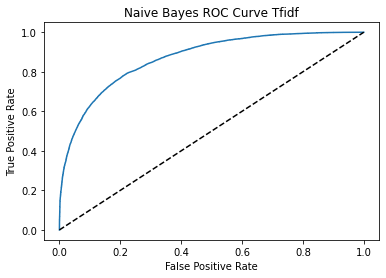

In [71]:
# Save this roc

plot_roc(X_train_T, y_train_T, vec_type='Tfidf')

#### Random Forest Classifier

In [264]:
 def eval_random_forest(X, y, folds=10, n_estimators=100, max_depth=5, max_leaf=None, max_features='log2'):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    oob = []
    iters = 0
    
    for train, test in kf.split(X):
        forest = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, n_jobs=-1, 
                                        max_leaf_nodes=max_leaf, max_features=max_features, 
                                        oob_score=True)
        forest.fit(X.iloc[train], y.iloc[train])
        accuracy.append(forest.score(X.iloc[test], y.iloc[test]))
        oob.append(forest.oob_score_)
        
        print(iters)
        iters += 1
    
    return np.mean(accuracy), np.mean(oob), forest

In [159]:
score, model = eval_random_forest(X_train, y_train, folds=10, 
                                  n_estimators=10, max_depth=10, max_leaf=None)
print(score)

0.31232727272727273


0.31224242424242427 =  folds=10, n_estimators=100, max_depth=5, max_leaf=None

0.31224242424242427 =  folds=10, n_estimators=10, max_depth=5, max_leaf=None

0.31224242424242427 =  folds=10, n_estimators=10, max_depth=10, max_leaf=None

0.3122060606060606  =  folds=10, n_estimators=100, max_depth=10, max_leaf=100

0.3122787878787879  =  folds=100, n_estimators=100, max_depth=10, max_leaf=100

0.31220606060606065 = folds=10, n_estimators=10, max_depth=10, max_leaf=10

In [154]:
model.n_features_

1

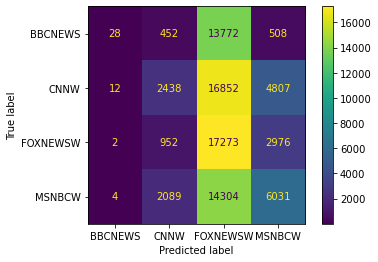

In [138]:
# 0.31224242424242427 =  folds=10, n_estimators=100, max_depth=5, max_leaf=None
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [17]:
def test_forest_folds(X, y, fold_lst):
    accuracy = []
    for folds in fold_lst:
        accuracy.append(eval_random_forest(X, y, folds=folds))
        
    return accuracy

def test_forest_depth(X, y, depth_lst):
    accuracy = []
    for depth in depth_lst:
        accuracy.append(eval_random_forest(X, y, max_depth=depth))
        
    return accuracy

def test_forest_estimators(X, y, est_lst):
    accuracy = []
    for est in est_lst:
        accuracy.append(eval_random_forest(X, y, n_estimators=est, max_depth=50))
        
    return accuracy

def test_max_leafs(X, y, leaf_lst):
    accuracy = []
    for leaf in leaf_lst:
        accuracy.append(eval_random_forest(X, y, max_leaf=leaf))
        
    return accuracy

def plot_folds_random_forest_folds(X, y, fold_lst):
    fig, ax = plt.subplots()
    xs = fold_lst
    ys = test_forest_folds(X, y, fold_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Folds')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Folds');
    
def plot_depth_random_forest(X, y, depth_lst):
    fig, ax = plt.subplots()
    xs = depth_lst
    ys = test_forest_depth(X, y, depth_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Depth')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Depth');

In [164]:
depth = [5, 10, 20, 30, 100]
test_forest_depth(X_train, y_train, depth)

[(0.31220606060606054,
  RandomForestClassifier(max_depth=5, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.31231515151515155,
  RandomForestClassifier(max_depth=10, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.31225454545454545,
  RandomForestClassifier(max_depth=20, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.31225454545454545,
  RandomForestClassifier(max_depth=30, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.3122181818181818,
  RandomForestClassifier(max_depth=100, max_features=None, n_estimators=10,
                         n_jobs=-1))]

In [176]:
test_forest_depth(X_train, y_train, [500])

[(0.31221818181818184,
  RandomForestClassifier(max_depth=500, max_features=None, n_jobs=-1))]

In [170]:
estimators = [5, 10, 20, 30, 50]
test_forest_estimators(X_train, y_train, estimators)

[(0.31225454545454545,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=5,
                         n_jobs=-1)),
 (0.312169696969697,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.3122666666666667,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=20,
                         n_jobs=-1)),
 (0.3122545454545454,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=30,
                         n_jobs=-1)),
 (0.312230303030303,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=50,
                         n_jobs=-1))]

In [177]:
leafs = [5, 10, 20, 30, 50]
test_max_leafs(X, y, leafs)

[(0.2632,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=5,
                         n_jobs=-1)),
 (0.2632,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=10,
                         n_jobs=-1)),
 (0.27559999999999996,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=20,
                         n_jobs=-1)),
 (0.25360000000000005,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=30,
                         n_jobs=-1)),
 (0.2604,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=50,
                         n_jobs=-1))]

In [139]:
score_T, model_T = eval_random_forest(X_train_T, y_train_T)
print(score)

0.31224242424242427


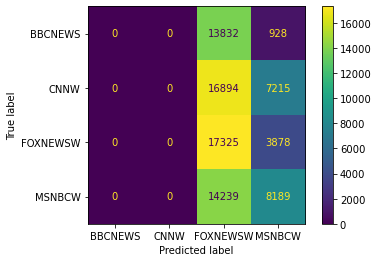

In [140]:
plot_confusion_matrix(model_T, X_train_T, y_train_T)  
plt.show()

##### With only summer for MSNBC/Fox

In [24]:
score, model = eval_random_forest(X_train, y_train, folds=5, n_estimators=10, max_depth=10, max_leaf=10)
print(score)

0
1
2
3
4
0.5805743487596651


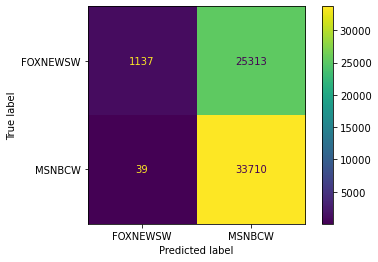

In [25]:
# Random forest confusion matrix
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [22]:
score, model = eval_random_forest(X_train, y_train, folds=10, n_estimators=100, max_depth=10, max_leaf=10)
print(score)

0
1
2
3
4
5
6
7
8
9
0.5659229632189098


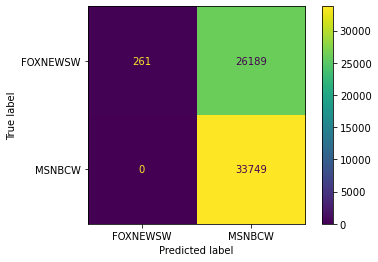

In [23]:
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [19]:
X_train.shape

(60199, 1901)

In [75]:
depth = [5, 10, 20, 30, 100]
test_forest_depth(X_train, y_train, depth)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


[(0.5608897240686883,
  RandomForestClassifier(max_depth=5, max_features='log2', n_jobs=-1)),
 (0.5713715675554543,
  RandomForestClassifier(max_depth=10, max_features='log2', n_jobs=-1)),
 (0.6248443191245441,
  RandomForestClassifier(max_depth=20, max_features='log2', n_jobs=-1)),
 (0.6737985802434043,
  RandomForestClassifier(max_depth=30, max_features='log2', n_jobs=-1)),
 (0.8132361116707392,
  RandomForestClassifier(max_depth=100, max_features='log2', n_jobs=-1))]

In [80]:
depth = [45, 60, 75, 90]
test_forest_depth(X_train, y_train, depth)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


[(0.7266401522531916,
  RandomForestClassifier(max_depth=45, max_features='log2', n_jobs=-1)),
 (0.7589328311951247,
  RandomForestClassifier(max_depth=60, max_features='log2', n_jobs=-1)),
 (0.7967574883301439,
  RandomForestClassifier(max_depth=75, max_features='log2', n_jobs=-1)),
 (0.8079868208038885,
  RandomForestClassifier(max_depth=90, max_features='log2', n_jobs=-1))]

In [265]:
# save this model ... Accuracy = 0.8136348738408108, OOB = 0.8073186924280928
# importance parameter for acccurracy is max_depth. deeper=better_accuracy (have not tested above 100..)
accuracy, oob, forest = eval_random_forest(X_train, y_train, folds=10, n_estimators=100, max_depth=100)
print(f'Accuracy = {accuracy}, OOB = {oob}')

0
1
2
3
4
5
6
7
8
9
Accuracy = 0.8136348738408108, OOB = 0.8073186924280928


##### ROC Curve

In [78]:
def plot_roc_forest(X, y, vec_type='(Count)', max_depth=10):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y_net, train_size=0.33, shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = RandomForestClassifier(max_depth=max_depth, max_features='log2', n_jobs=-1)
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_hat[:,1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_title(f'Random Forest ROC Curve {vec_type}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return thresh

array([2.00000000e+00, 1.00000000e+00, 9.98571429e-01, ...,
       2.00000000e-03, 1.11111111e-03, 0.00000000e+00])

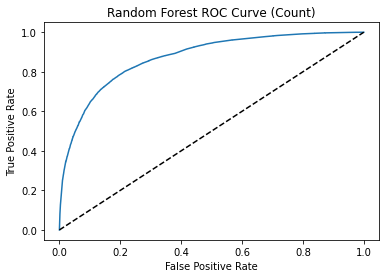

In [81]:
plot_roc_forest(X_train, y_train, vec_type='(Count)')

In [303]:
# feature importance 
from sklearn.inspection import permutation_importance, plot_partial_dependence, partial_dependence

# gini
def chart_gini_import(model, X, size=15):
    fig, ax = plt.subplots()
    feature_scores = pd.Series(model.feature_importances_, index=X.columns)
    feature_scores = feature_scores.sort_values()
    ax = feature_scores[:15].plot(kind='barh', figsize=(10,4))
    ax.set_title('Gini Importance')
    ax.set_xlabel('Avg. Contribution to Info Gain');

# permutations
def chart_permutation_import(model, X, y, size=15, n_repeats=5):
    fig, ax = plt.subplots()
    perms = permutation_importance(model, X, y, n_repeats=n_repeats)
    sorted_idx = perms.importances_mean.argsort()
    ax.boxplot(perms.importances[sorted_idx[:size]].T, vert=False, labels=X.columns[sorted_idx])
    ax.set_title('Permutation Importance');

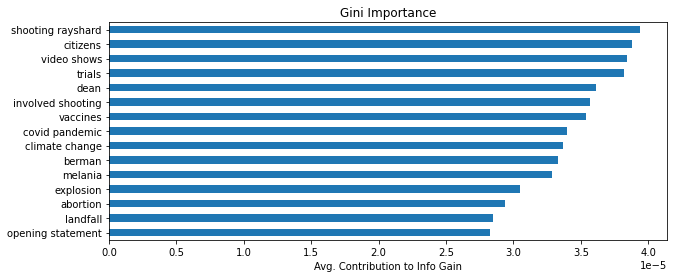

In [304]:
# gini no n-grams
chart_gini_import(forest, X_train)

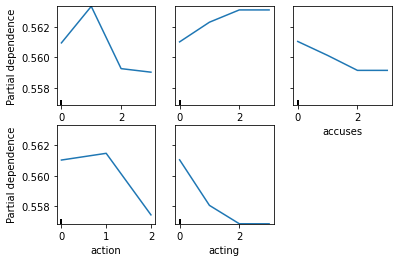

In [278]:
plot_partial_dependence(forest, X_train, features = ['across', 'act', 'accuses', 'action', 'acting'])

In [26]:
X_test.shape

(122225, 2282)

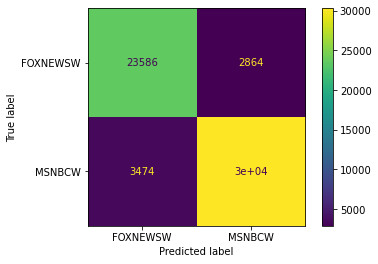

In [281]:
plot_confusion_matrix(forest, X_train, y_train)  

##### EDA

In [12]:
word_counts = get_dataframe(count_vec, feature_count)

In [25]:
len(feature_count)

2282

In [82]:
tfidf_frame = get_dataframe(tfidf_vec, feature_tfidf)

In [13]:
word_counts['network'] = chy_nets['channel']

In [14]:
type(chy_nets['channel']), type(word_counts)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [15]:
word_counts = word_counts.assign(network=chy_nets['channel'].values)

In [16]:
fox_words = word_counts.loc[word_counts['network'] == 'FOXNEWSW']
nbc_words = word_counts.loc[word_counts['network'] == 'MSNBCW']

In [17]:
fox_words.drop('network', axis=1, inplace=True)
top_fox_words = fox_words.sum().sort_values(ascending=False)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
nbc_words.drop('network', axis=1, inplace=True)
top_nbc_words = nbc_words.sum().sort_values(ascending=False)

In [19]:
top_fox_words[:25]

trump              24826
biden              11558
president           8573
police              7162
president trump     6503
covid               3805
protests            3724
court               3412
house               3350
news                3225
com                 3141
campaign            2600
cities              2514
election            2485
supreme             2462
debate              2405
white               2388
violence            2328
supreme court       2317
coronavirus         2297
protesters          2271
floyd               2164
sen                 2156
white house         2130
america             2118
dtype: int64

In [20]:
top_nbc_words[:25]

trump          55196
biden          15621
covid           9413
cases           8952
virus           8247
police          6784
house           6249
pres            5771
election        5570
protests        5463
coronavirus     5272
pres trump      5131
white           4917
sen             4540
president       4466
harris          4427
floyd           4209
campaign        4165
white house     4063
dr              3904
death           3784
rep             3747
states          3727
court           3562
george          3518
dtype: int64

In [87]:
tfidf_frame = tfidf_frame.assign(network=chy_nets['channel'].values)

In [88]:
fox_tfidf = word_counts.loc[word_counts['network'] == 'FOXNEWSW']
nbc_tfidf = word_counts.loc[word_counts['network'] == 'MSNBCW']

In [91]:
nbc_tfidf.head()

,abortion,absentee,abuse,accept,accepts,access,accused,accuses,acks,acres,...,writer,wrong,wsj,year,years,yet,york,young,zone,network
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MSNBCW
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MSNBCW
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MSNBCW
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MSNBCW
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MSNBCW


In [112]:
fox_top_tfidf = fox_tfidf.max().T.squeeze()

In [115]:
fox_top_tfidf = fox_top_tfidf.sort_values(ascending=False)

In [116]:
fox_top_tfidf[:25]

one         6
tests       6
enough      6
win         6
campaign    6
service     6
ill         6
trump       6
police      6
nl          5
dhs         5
storm       5
stop        5
smith       5
san         5
crime       5
cdc         5
kelly       5
delay       5
mayor       5
news        5
football    5
debate      5
city        5
sanders     5
dtype: int64

In [117]:
fox_tfidf_sum = fox_tfidf.sum().sort_values(ascending=False)


In [123]:
nbc_tfidf.drop('network', axis=1, inplace=True)
nbc_top_tfidf = nbc_tfidf.max().T.squeeze()
# nbc_top_tfidf = nbc_top_tfidf.sort_values(ascending=False)

/Users/jonleckie/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [127]:
# nbc_top_tfidf.sort_values(ascending=False)
nbc_top_tfidf = nbc_top_tfidf.sort_values(ascending=False)
nbc_top_tfidf[:25]

ui        8
trump     7
anu       6
wind      6
un        6
one       6
lewis     6
li        6
iu        6
ai        6
ul        6
blake     6
mayor     6
obama     5
like      5
police    5
im        5
latino    5
ihi       5
uk        5
voters    5
floyd     5
biden     5
women     5
al        5
dtype: int64

In [22]:
nbc_word_counts = nbc_words.sum()
fox_word_counts = fox_words.sum()

In [28]:
len(nbc_word_counts)

2282

In [29]:
len(fox_word_counts)

2282

In [92]:
def chart_top(word_lst, network, low=0, high=10,):
    fig, ax = plt.subplots(figsize=(10,4))
    
    ax.barh(word_lst.index[low:high], word_lst.values[low:high], align='center')
    ax.invert_yaxis()
    ax.set_title(f'Top Word Counts: {network}')
    ax.set_ylabel('Words')
    ax.set_xlabel('Counts');

In [93]:
list(top_nbc_words.index[:5])

['trump', 'biden', 'ntrump', 'covid', 'cases']

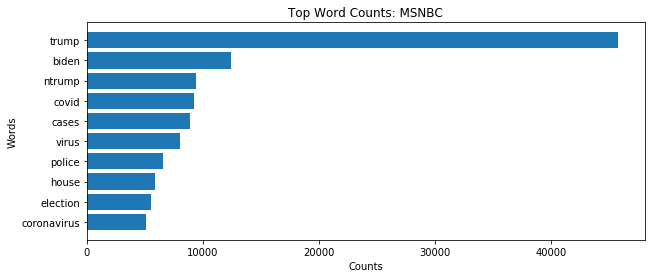

In [94]:
chart_top(top_nbc_words, 'MSNBC', low=0, high=10)

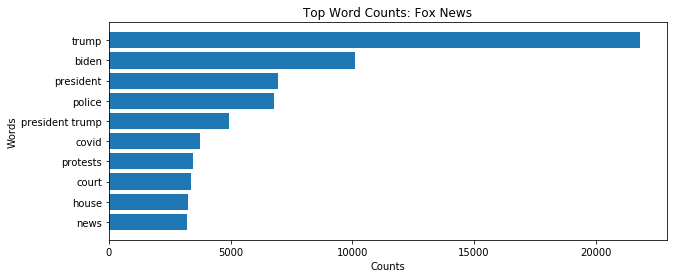

In [95]:
chart_top(top_fox_words, 'Fox News', low=0, high=10)

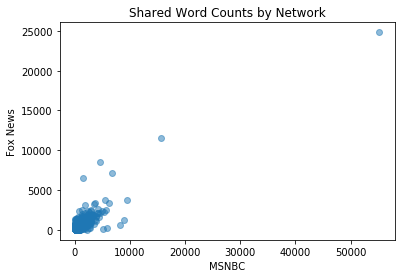

In [27]:
fig, ax = plt.subplots()

ax.scatter(nbc_word_counts, fox_word_counts, alpha=0.5)
ax.set_title('Shared Word Counts by Network')
ax.set_xlabel('MSNBC')
ax.set_ylabel('Fox News');

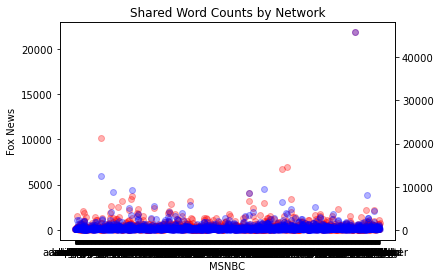

In [173]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
xs = word_counts.columns[:-1]

ax1.scatter(xs, fox_words.sum(), alpha=0.3, color='red')
ax2.scatter(xs, nbc_words.sum(), alpha=0.3, color='blue')
ax1.set_title('Shared Word Counts by Network')
ax1.set_xlabel('MSNBC')
ax1.set_ylabel('Fox News');

In [171]:
len(xs), len(fox_words.sum()), len(nbc_words.sum())

(1902, 1901, 1901)

In [283]:
def chart_shared_word_counts(thresh=20000):
    fig, ax = plt.subplots()
    nbc_lt = []
    fox_lt = []
    words = []
    
    for i, word in enumerate(nbc_word_counts):
        if word < thresh:
            nbc_lt.append(nbc_word_counts[i])
            fox_lt.append(fox_word_counts[i])
        
    ax.scatter(nbc_lt, fox_lt, alpha=0.3)
    ax.set_title('Shared Word Counts by Network')
    ax.set_xlabel('MSNBC')
    ax.set_ylabel('Fox News');

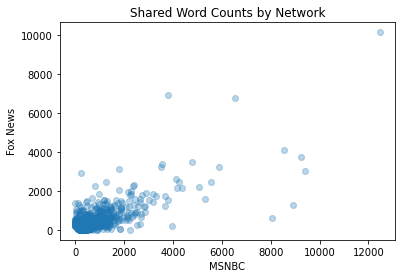

In [284]:
chart_word_counts(thresh=10000)

In [178]:
# nbc_word_counts.loc[nbc_word_counts.values > 0 & nbc_word_counts.values < 2000]
nbc_word_counts.values

array([ 168,  257,  155, ..., 1051,  410,  188])

##### NMF

In [30]:
len(nbc_word_counts)

2282

In [31]:
len(fox_word_counts)

2282

In [38]:
nbc_zero = []
for word in nbc_word_counts:
    if word == 0:
        nbc_zero.append(word)
        
fox_zero = []
for word in fox_word_counts:
    if word == 0:
        nbc_zero.append(word)

In [39]:
len(nbc_zero), len(fox_zero)

(53, 0)

In [35]:
nbc_word_counts[0]

169

In [ ]:
def fit_nmf(X, n_components=2):
    
    nmf = NMF(n_components=n_components)
    W = nmf.fit_transform(X)
    H = nmf.components_